In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-1f9b334e-816d-ffdb-6a56-1dacbbc246d7)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Necessary Libraries
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential

# extracting features of each photo that are in the directory
def extract_features(directory):
    # load the model
    #model_resnet50 = ResNet50() #initialising resnet50 model
    #model_InceptionV3 = InceptionV3() #Initialising InceptionV3 model
    model_vgg16 = VGG16()
    model = Sequential()
    # re-structuring the model
    #removing the classification layer
    for layer in model_vgg16.layers[:-1]:
        model.add(layer)
    
    #printing model summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshaping data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features

# extract features from all images
directory = '/content/drive/MyDrive/Flickr8k/Images/' #directory where the images are present
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to a pickle file
dump(features, open('VGG16.pkl', 'wb'))

Streaming output truncated to the last 5000 lines.
>3139160252_75109e9e05.jpg
>315021440_122d56ebd7.jpg
>3136688093_568b053bdf.jpg
>3151860914_46e30cd5ea.jpg
>3154813159_58a195236d.jpg
>3154152744_4e93ec8a62.jpg
>3146630574_05d9ebbed1.jpg
>3142055158_01b9e4caa4.jpg
>3143574389_8a4048fbe2.jpg
>3139393607_f0a54ca46d.jpg
>3143953179_1c08c023a5.jpg
>3145967019_1a83ebf712.jpg
>3145967309_b33abe4d84.jpg
>3143159297_6f2f663ea6.jpg
>3145869775_85dfae43bd.jpg
>3143155555_32b6d24f34.jpg
>3148647065_2d6cd88cf6.jpg
>3150659152_2ace03690b.jpg
>3155987659_b9ea318dd3.jpg
>3157622277_9f59b4f62f.jpg
>314940358_ec1958dc1d.jpg
>3149919755_f9272b10b3.jpg
>3155400369_69e3d6d70f.jpg
>3138746531_f6b816c126.jpg
>3141293960_74459f0a24.jpg
>3156991513_3bf03333d8.jpg
>3147217787_ed21cd4990.jpg
>3141440149_00becbbb93.jpg
>3135826945_f7c741e5b7.jpg
>3155365418_43df5486f9.jpg
>3155501473_510f9c9f6b.jpg
>3148286846_40ae914172.jpg
>3138504165_c7ae396294.jpg
>3139118874_599b30b116.jpg
>3154641421_d1b9b8c24c.jpg
>31488

In [ ]:
import string

# load doc into memory
def load_doc(filename):
    file = open(filename, 'r', encoding ='utf-8') # open the file as read only
    # read all text
    text = file.read()
    file.close()
    return text

# extract descriptions for images
def load_descriptions(doc):
    mapping = dict() #initialising dictionary
    # process lines in the text file
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # creating a list
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    # removing ounctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # storing as string
            desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()


filename = '/content/drive/MyDrive/dataset1/Flickr8k_text/Flickr8k_HinditxtClean.txt'
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8091 
Vocabulary Size: 446


In [ ]:
from pickle import load


def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# load training dataset (6K)
filename = '/content/drive/MyDrive/dataset1/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/dataset1/Flickr8k_text/Flickr8k_HinditxtClean.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('VGG16.pkl', train)
print('Photos: train=%d' % len(train_features))
train_descriptions


Dataset: 6000
Descriptions: train=6000
Photos: train=6000


{'1000268201_693b08cb0e': ['startseq गुलाबी पोशाक में एक बच्चा प्रवेश के रास्ते में सीढ़ियों के एक सेट पर चढ़ रहा है। endseq',
  'startseq एक लड़की लकड़ी की इमारत में जा रही है। endseq',
  'startseq एक छोटी लड़की लकड़ी के प्लेहाउस में चढ़ गई। endseq',
  'startseq एक छोटी सी लड़की अपने प्लेहाउस में सीढ़ियाँ चढ़ रही थी। endseq',
  'startseq एक गुलाबी पोशाक में एक छोटी लड़की एक लकड़ी के केबिन में जा रही है। endseq'],
 '1001773457_577c3a7d70': ['startseq एक काला कुत्ता और एक चित्तीदार कुत्ता लड़ रहे हैं endseq',
  'startseq एक काला कुत्ता और सड़क पर एक दूसरे के साथ खेलता हुआ एक तिरंगा कुत्ता। endseq',
  'startseq एक काले कुत्ते और भूरे रंग के धब्बे वाला एक सफेद कुत्ता सड़क पर एक दूसरे को घूर रहा है। endseq',
  'startseq सड़क पर एक-दूसरे को देख अलग-अलग नस्लों के दो कुत्ते। endseq',
  'startseq फुटपाथ पर दो कुत्ते एक दूसरे की ओर बढ़ते हुए। endseq'],
 '1002674143_1b742ab4b8': ['startseq पेंट में ढकी एक छोटी लड़की एक कटोरे में अपने हाथों से चित्रित इंद्रधनुष के सामने बैठती है। endseq',
  'star

In [ ]:
from numpy import array
import tensorflow
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint



def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text


def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)


def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions


def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# get vocabulary size
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo):
	X1, X2, y = list(), list(), list()
	# loop through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = Bidirectional(LSTM(128, return_sequences = True))(se2)
    se4 = Bidirectional(LSTM(128))(se3)
    
	# decoder model
    decoder1 = add([fe2, se4])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
	# summarize model
    print(model.summary())
    return model





Vocabulary Size: 8652


In [ ]:
# #LSTM Model
# # define the captioning model
# def define_model(vocab_size, max_length):
# 	# feature extractor model
# 	inputs1 = Input(shape=(4096,))
# 	fe1 = Dropout(0.5)(inputs1)
# 	fe2 = Dense(256, activation='relu')(fe1)
# 	# sequence model
# 	inputs2 = Input(shape=(max_length,))
# 	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# 	se2 = Dropout(0.5)(se1)
# 	se3 = LSTM(256)(se2)
# 	# decoder model
# 	decoder1 = add([fe2, se3])
# 	decoder2 = Dense(256, activation='relu')(decoder1)
# 	outputs = Dense(vocab_size, activation='softmax')(decoder2)
# 	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# 	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
# 	# summarize model
# 	print(model.summary())
# 	return model

In [ ]:
#progressively loading the batch of data
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
	# loop over every image
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
			yield (in_img, in_seq), out_word

In [ ]:
from pickle import dump
filename = '/content/drive/MyDrive/dataset1/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/dataset1/Flickr8k_text/Flickr8k_HinditxtClean.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
train_features = load_photo_features('VGG16.pkl', train)
print('Photos: train=%d' % len(train_features))
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)


Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 8652
Description Length: 39


In [ ]:
# train the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 10
steps = len(train_descriptions) 
loss = []
accuracy = []
for i in range(epochs):
    # creating the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    # fit for one epoch
    history = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss.append(history.history['loss'])
    accuracy.append(history.history['accuracy'])
    # save model
    model.save('model_' + str(i) + '.h5')


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 39)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 39, 256)      2214912     ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dropout_3 (Dropout)            (None, 39, 256)      0           ['embedding_1[0][0]']            
                                                                                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


6000/6000 [==============================] - 2213s 366ms/step - loss: 4.3325 - accuracy: 0.2880


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


6000/6000 [==============================] - 2194s 366ms/step - loss: 2.7700 - accuracy: 0.4356


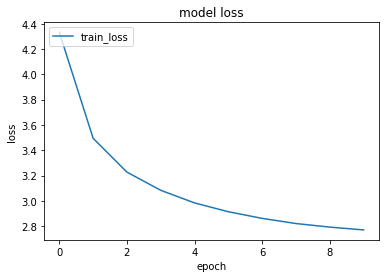

In [ ]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss'], loc='upper left')
plt.show()

In [ ]:
#Entire code with all the functions to calculate the BLUE score
from pickle import dump
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu


def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text


def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)


def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions


def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features


def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc


def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer


def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)


def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# evaluate the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	#loop over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# prepare training set

filename = '/content/drive/MyDrive/dataset1/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/dataset1/Flickr8k_text/Flickr8k_HinditxtClean.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare test set

# load test set
filename = '/content/drive/MyDrive/dataset1/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('/content/drive/MyDrive/dataset1/Flickr8k_text/Flickr8k_HinditxtClean.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('VGG16.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model which has minimum loss
filename = 'model_9.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 8652
Description Length: 39
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.583406
BLEU-2: 0.404817
BLEU-3: 0.277117
BLEU-4: 0.129250


In [ ]:
from pickle import load
from numpy import argmax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3

# extract features from each photo in the directory for VGG

def ExtractFeatures(file_name):
    model = VGG16()
    model_vgg16 = VGG16()
    model = Sequential()

    for layer in model_vgg16.layers[:-1]:
        model.add(layer)
    img = load_img(file_name, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    img_feature = model.predict(img, verbose=0)
    return img_feature

# map an integer to a word
def WordForId(integer, tokenizer):
	for w, i in tokenizer.word_index.items():
		if i == integer:
			return w
	return None

# generate a description for an image
def GenerateDesc(model, tokenizer, image, maxLength):
	start_text = 'startseq'
	for i in range(maxLength):
		seq = tokenizer.texts_to_sequences([start_text])[0]
		seq = pad_sequences([seq], maxlen=maxLength)
		yword = model.predict([image,seq], verbose=0)
		yword = argmax(yword)
		word = WordForId(yword, tokenizer)
		if word is None:
			break
		start_text += ' ' + word
		if word == 'endseq':
			break
	return start_text

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 39
# load the model
model = load_model('model_9.h5')
# load and prepare the photograph
photo = ExtractFeatures('/content/drive/MyDrive/Flickr8k/Images/997722733_0cb5439472.jpg')
# generate description
description = GenerateDesc(model, tokenizer, photo, max_length)
print(description)



startseq एक आदमी एक चट्टान पर चढ़ रहा है। endseq


Populating the interactive namespace from numpy and matplotlib


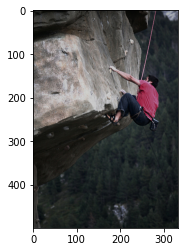

In [3]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/drive/MyDrive/Flickr8k/Images/997722733_0cb5439472.jpg')
imgplot = plt.imshow(img)
plt.show()